# 📊 Uber Trip Demand Analysis & Forecasting

## 📌 Project Overview

This project analyzes Uber operational trip data to identify demand patterns and build a predictive model for daily trip demand across dispatching bases.

The dataset contains daily aggregated information on:
- Dispatching base number
- Active vehicles (capacity)
- Total trips (demand output)

---

## 🎯 Business Objective

The primary objectives of this project are:

1. Identify demand patterns such as:
   - Busiest days of the week
   - Demand trends over time
   - Base-level efficiency

2. Analyze capacity-demand alignment.

3. Develop a machine learning model to predict daily trip demand.

---

## 📈 Machine Learning Problem Type

- Problem Type: Supervised Learning
- Task: Regression
- Target Variable: `trips`
- Evaluation Metrics: MAE, RMSE, R²

---

## 🧠 Modeling Strategy

- Time-based train-test split
- Feature engineering (time features + lag features)
- Baseline model: Linear Regression
- Advanced model: Random Forest
- Model interpretation using feature importance

# Import Libraries

In [40]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load & Inspect Data

In [41]:
# Load dataset
df = pd.read_csv("Uber-Jan-Feb-FOIL.csv")


In [42]:
# View first rows
df.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [43]:
# Check structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB


In [44]:
# Statistical summary
df.describe()

,active_vehicles,trips
count,354.000000,354.000000
mean,1307.435028,11667.316384
std,1162.510626,10648.284865
min,112.000000,629.000000
25%,296.750000,2408.500000
50%,1077.000000,9601.000000
75%,1417.000000,13711.250000
max,4395.000000,45858.000000


# Data Cleaning & Preprocessing

####  Convert Date Column

In [45]:
# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])

#### Check Missing Values

In [46]:
df.isnull().sum()

dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
dtype: int64

In [47]:
df.isnull().mean()*100

dispatching_base_number    0.0
date                       0.0
active_vehicles            0.0
trips                      0.0
dtype: float64

#### Sort Data (Important for Time Series)

In [48]:
df = df.sort_values(['dispatching_base_number', 'date'])

# Visual Outlier Detection (Boxplot)

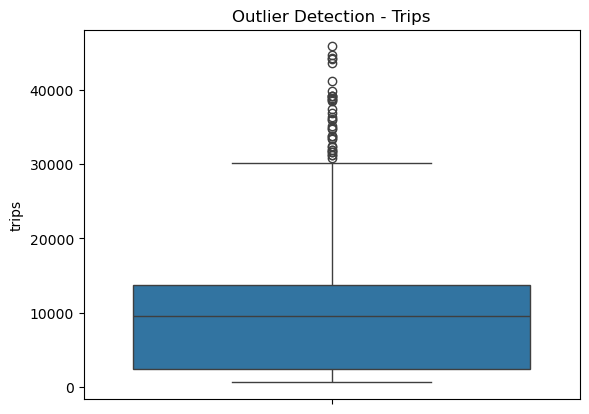

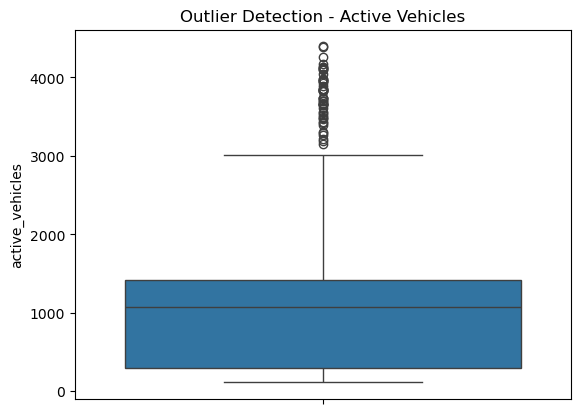

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.boxplot(y=df['trips'])
plt.title("Outlier Detection - Trips")
plt.show()

plt.figure()
sns.boxplot(y=df['active_vehicles'])
plt.title("Outlier Detection - Active Vehicles")
plt.show()

# IQR Method (Statistical Detection)

In [50]:
Q1 = df['trips'].quantile(0.25)
Q3 = df['trips'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['trips'] < lower_bound) | (df['trips'] > upper_bound)]

print("Number of outliers:", len(outliers))

Number of outliers: 35


In [51]:
def detect_outliers(group):
    Q1 = group['trips'].quantile(0.25)
    Q3 = group['trips'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return group[(group['trips'] < lower) | (group['trips'] > upper)]

outliers_per_base = df.groupby('dispatching_base_number').apply(detect_outliers)

len(outliers_per_base)

4

There are outliers but its not an issue of error, so we dont need  remove or handle it

# Exploratory Data Analysis (EDA)

#### Total Trips Over Time

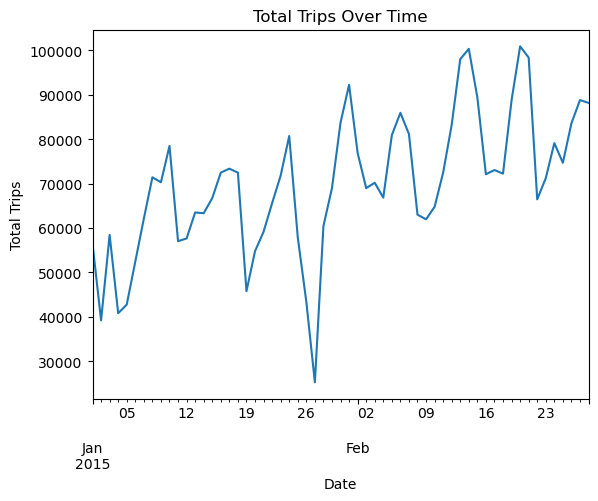

In [52]:
daily_trips = df.groupby('date')['trips'].sum()

plt.figure()
daily_trips.plot()
plt.title("Total Trips Over Time")
plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.show()

### 🔎 Observation

The total number of trips fluctuates over time, indicating changing demand levels. 
Certain peaks suggest higher demand periods, possibly influenced by weekly patterns or operational scaling.

#### Busiest Days of Week

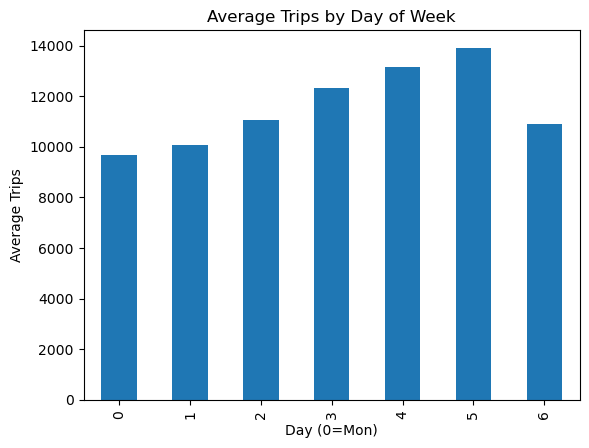

In [53]:
df['day_of_week'] = df['date'].dt.dayofweek

weekday_avg = df.groupby('day_of_week')['trips'].mean()

plt.figure()
weekday_avg.plot(kind='bar')
plt.title("Average Trips by Day of Week")
plt.xlabel("Day (0=Mon)")
plt.ylabel("Average Trips")
plt.show()

### 🔎 Observation

Trip demand varies by day of the week, indicating weekly seasonality. 
This confirms that day-of-week is an important feature for demand forecasting.

#### Trips per Vehicle (Efficiency)

In [54]:
df['trips_per_vehicle'] = df['trips'] / df['active_vehicles']

base_efficiency = df.groupby('dispatching_base_number')['trips_per_vehicle'].mean()

base_efficiency.sort_values(ascending=False)

dispatching_base_number
B02682    9.161441
B02598    9.133922
B02617    9.024466
B02764    8.754156
B02765    8.105404
B02512    7.073431
Name: trips_per_vehicle, dtype: float64

### 🔎 Observation

Trips per vehicle differs across dispatching bases, suggesting variation in operational efficiency. 
Bases with higher trips per vehicle may indicate stronger localized demand or better resource utilization.

#### Before Performing Feature Engineering i made a copy of  original data ( its for nothing its just for backup purpose).Before performing feature engineering, creating a copy of the original dataset is essential to preserve data integrity, ensure reproducibility, and allow rollback in case transformations introduce errors or unintended bias.

In [55]:
df_original = df.copy()
df.to_csv("uber_data_raw_backup.csv", index=False)

In [56]:
df

,dispatching_base_number,date,active_vehicles,trips,day_of_week,trips_per_vehicle
0,B02512,2015-01-01,190,1132,3,5.957895
8,B02512,2015-01-02,175,875,4,5.000000
16,B02512,2015-01-03,173,1088,5,6.289017
18,B02512,2015-01-04,147,791,6,5.380952
24,B02512,2015-01-05,194,984,0,5.072165
...,...,...,...,...,...,...
329,B02765,2015-02-24,698,6390,1,9.154728
332,B02765,2015-02-25,706,6178,2,8.750708
340,B02765,2015-02-26,745,6744,3,9.052349
342,B02765,2015-02-27,786,7563,4,9.622137


In [57]:
df_original

,dispatching_base_number,date,active_vehicles,trips,day_of_week,trips_per_vehicle
0,B02512,2015-01-01,190,1132,3,5.957895
8,B02512,2015-01-02,175,875,4,5.000000
16,B02512,2015-01-03,173,1088,5,6.289017
18,B02512,2015-01-04,147,791,6,5.380952
24,B02512,2015-01-05,194,984,0,5.072165
...,...,...,...,...,...,...
329,B02765,2015-02-24,698,6390,1,9.154728
332,B02765,2015-02-25,706,6178,2,8.750708
340,B02765,2015-02-26,745,6744,3,9.052349
342,B02765,2015-02-27,786,7563,4,9.622137


# Feature Engineering (Critical for ML)

#### Time-Based Features

In [58]:
df['month'] = df['date'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

#### Lag Features (Very Important for Demand Prediction)

In [59]:
# Create lag features per base
df['lag_1'] = df.groupby('dispatching_base_number')['trips'].shift(1)
df['lag_7'] = df.groupby('dispatching_base_number')['trips'].shift(7)

In [60]:
df

,dispatching_base_number,date,active_vehicles,trips,day_of_week,trips_per_vehicle,month,is_weekend,lag_1,lag_7
0,B02512,2015-01-01,190,1132,3,5.957895,1,0,NaN,NaN
8,B02512,2015-01-02,175,875,4,5.000000,1,0,1132.0,NaN
16,B02512,2015-01-03,173,1088,5,6.289017,1,1,875.0,NaN
18,B02512,2015-01-04,147,791,6,5.380952,1,1,1088.0,NaN
24,B02512,2015-01-05,194,984,0,5.072165,1,0,791.0,NaN
...,...,...,...,...,...,...,...,...,...,...
329,B02765,2015-02-24,698,6390,1,9.154728,2,0,5823.0,4907.0
332,B02765,2015-02-25,706,6178,2,8.750708,2,0,6390.0,5059.0
340,B02765,2015-02-26,745,6744,3,9.052349,2,0,6178.0,6447.0
342,B02765,2015-02-27,786,7563,4,9.622137,2,0,6744.0,7824.0


#### Drop NA Created by Lag

In [61]:
df = df.dropna()

#### Encode Categorical Variable

In [62]:
df = pd.get_dummies(df, columns=['dispatching_base_number'], drop_first=True)

# Define Features & Target

In [63]:
# Target variable
y = df['trips']

# Feature variables
X = df.drop(columns=['trips', 'date'])

# Train-Test Split (Time-Based Split)

In [64]:
split_date = df['date'].max() - pd.Timedelta(days=14)

train = df[df['date'] <= split_date]
test = df[df['date'] > split_date]

X_train = train.drop(columns=['trips', 'date'])
y_train = train['trips']

X_test = test.drop(columns=['trips', 'date'])
y_test = test['trips']

# Time-Series Cross Validation

In [65]:
# Time Series Cross Validation (More robust evaluation)

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

rf_cv = RandomForestRegressor(n_estimators=200, random_state=42)

mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    rf_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = rf_cv.predict(X_test_cv)
    
    mae_scores.append(mean_absolute_error(y_test_cv, y_pred_cv))

print("Cross-Validation MAE Scores:", mae_scores)
print("Average MAE:", np.mean(mae_scores))

Cross-Validation MAE Scores: [7241.845961538462, 2401.5903846153847, 384.60990384615377, 19814.535384615385, 780.4390384615386]
Average MAE: 6124.604134615385


# Baseline Model (Linear Regression)

In [66]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Linear Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2:", r2_score(y_test, y_pred_lr))

Linear Regression Results:
MAE: 853.6137879510255
RMSE: 1206.575805579758
R2: 0.9884304995693616


# Advanced Model (Random Forest)

In [67]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest Results:
MAE: 423.3887499999999
RMSE: 691.8136641309377
R2: 0.9961964979673287


# Hyperparameter Tuning

In [68]:
# Hyperparameter Tuning using GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

print("Tuned Model MAE:", mean_absolute_error(y_test, y_pred_best))
print("Tuned Model RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Tuned Model R2:", r2_score(y_test, y_pred_best))

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Model MAE: 437.62928571428574
Tuned Model RMSE: 696.3929848905443
Tuned Model R2: 0.9961459782901724


# Feature Importance

In [69]:
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(10)

active_vehicles                   0.671662
lag_1                             0.136780
dispatching_base_number_B02764    0.116793
trips_per_vehicle                 0.037439
lag_7                             0.036007
day_of_week                       0.000993
month                             0.000184
is_weekend                        0.000049
dispatching_base_number_B02617    0.000033
dispatching_base_number_B02682    0.000029
dtype: float64

Purpose:

Identify strongest predictors

Understand drivers of demand

# Model Prediction Visualization

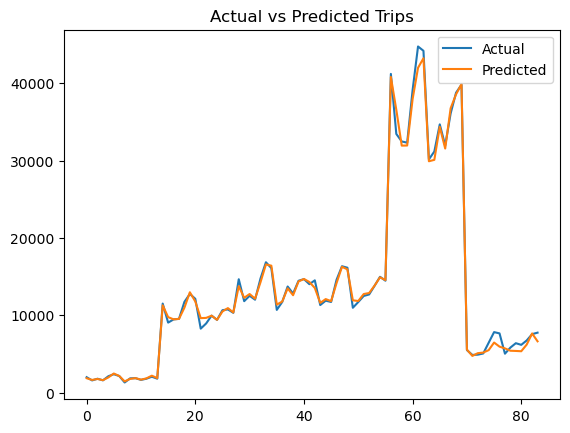

In [70]:
plt.figure()
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Trips")
plt.show()

# Residual Analysis (Model Diagnostics)

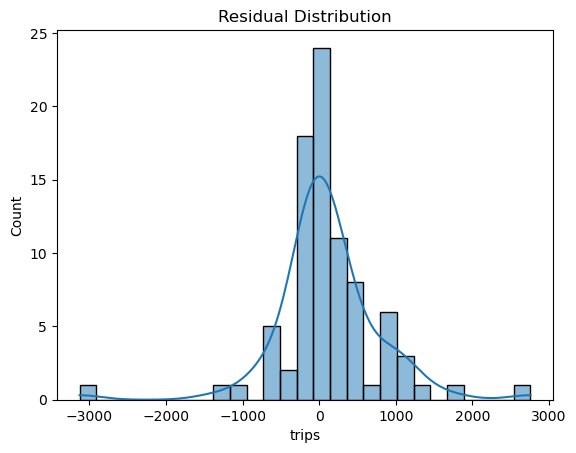

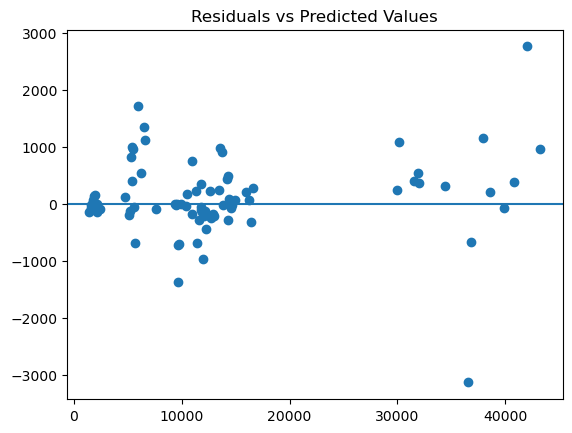

In [71]:
# Residual Analysis

residuals = y_test - y_pred_rf

plt.figure()
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

plt.figure()
plt.scatter(y_pred_rf, residuals)
plt.axhline(y=0)
plt.title("Residuals vs Predicted Values")
plt.show()

# 📌 Final Business Insights & Conclusion

## 🔎 Key Findings

- Trip demand shows clear weekly seasonality.
- Certain dispatching bases consistently outperform others in terms of efficiency.
- Lag features (previous day demand) strongly influence current demand.
- Active vehicles significantly impact trip output.

## 🤖 Model Performance

- Random Forest outperformed Linear Regression.
- Tree-based models captured nonlinear demand patterns better.
- Time-based validation ensured realistic evaluation.

The tuned Random Forest model was selected as the final model due to its superior MAE and RMSE performance compared to the baseline Linear Regression model.

## 📈 Business Impact

- Demand forecasting helps optimize vehicle deployment.
- Underperforming bases can be investigated further.
- High-demand days can be planned with increased capacity.

---

## 🚀 Future Improvements

- Incorporate weather data
- Include holiday/event indicators
- Try advanced models (XGBoost, LightGBM)
- Use rolling window forecasting